Muhammad Hassaan Azam

AI/ML Intern

DHC 831

# Task 2: Multi-Label Emotion Recognition from Text

## Important Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf

## Loading Dataset

The Google AI GoEmotions dataset consists of comments from Reddit users, labeled based on their emotional tone. It is designed to train neural networks for deep sentiment analysis and emotion classification.

Most existing emotion classification datasets are limited in scope, often focusing on specific domains such as news headlines or movie subtitles. Additionally, they tend to be small in size and classify emotions using only six basic categories: anger, surprise, disgust, joy, fear, and sadness. Expanding the emotional spectrum in datasets like GoEmotions enables the development of more nuanced AI applications, such as:

- Emotionally intelligent chatbots
- Models for detecting harmful online behavior
- Enhanced customer support systems

Google, in collaboration with psychologists, categorized emotions into:

- 12 positive emotions
- 11 negative emotions
- 4 ambiguous emotions
- 1 neutral category



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/go-emotions-google-emotions-dataset")

print("Path to dataset files:", path)

100%|██████████| 8.68M/8.68M [00:00<00:00, 91.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/go-emotions-google-emotions-dataset/versions/1


In [ ]:
import os

dataset = tf.io.gfile.glob(str(path + '/*'))

print(dataset)

['/root/.cache/kagglehub/datasets/shivamb/go-emotions-google-emotions-dataset/versions/1/go_emotions_dataset.csv']


In [ ]:
df = pd.read_csv(dataset[0])
df.head()

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.shape

(211225, 31)

In [ ]:
df.to_csv("emotion.csv", index=False) # Save the DataFrame 'df' to 'emotion.csv'
                                     # index=False prevents saving the DataFrame index

## Dataset Preprocessing

Converting Categories Columns into Single Column

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('emotion.csv')

# Select emotion columns (assuming they start from the 3rd column onward)
emotion_columns = df.columns[3:]

# Create a new categorical column by finding the index of the max value in each row
df['emotion'] = df[emotion_columns].idxmax(axis=1)

# Optionally, you can drop the one-hot encoded columns if no longer needed
df = df.drop(columns=emotion_columns)

# Display the updated DataFrame
df.head()

,id,text,example_very_unclear,emotion
0,eew5j0j,That game hurt.,False,sadness
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,admiration
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,neutral
3,eeibobj,Man I love reddit.,False,love
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,neutral


Total count of all categories

In [ ]:
df['emotion'].value_counts()

,count
emotion,
neutral,55298
admiration,20542
approval,15530
annoyance,11929
disapproval,8917
amusement,8862
gratitude,8437
anger,7956
curiosity,7707


In [ ]:
df['emotion'].value_counts().count()

28

We only need two columns for classification task

In [ ]:
df = df[['text', 'emotion']]
df.head()

,text,emotion
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,admiration
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


Intially we selected total 5 Categories

In [ ]:
df = df[df['emotion'].isin(['anger', 'love', 'joy', 'disappointment', 'sadness'])]
df.head()

,text,emotion
0,That game hurt.,sadness
3,Man I love reddit.,love
11,"I wanted to downvote this, but it's not your f...",disappointment
13,That is odd.,disappointment
32,"Dark and funny, but not really nice guy. He ha...",disappointment


From 5 selected classes, containing 7969 duplicate records.

In [ ]:
df.duplicated().sum()

7969

In [ ]:
df[df.duplicated()]

,text,emotion
2844,Aww yesss assalamu ‘alaykum akhi i love when i...,love
4323,"* [NAME] fought for freedom and glory, is one ...",love
5046,My condolences.,sadness
5218,I love [NAME] but its been 1 year,love
6025,Made by [NAME] who also was involved with Sacr...,joy
...,...,...
211118,Oh [NAME] i forgot about those. I used to love...,love
211177,i hate that it's over an interstate bridge so ...,anger
211179,"A joke is subjective pal, second of all you ne...",joy
211220,Everyone likes [NAME].,love


Example No. 1 of duplicate record

In [ ]:
df[df['text'] == 'I love [NAME] but its been 1 year']

,text,emotion
4603,I love [NAME] but its been 1 year,love
5218,I love [NAME] but its been 1 year,love
106140,I love [NAME] but its been 1 year,love
172888,I love [NAME] but its been 1 year,love


Example No. 2 of duplicate record

In [ ]:
df[df['text'] == 'Everyone likes [NAME].']

,text,emotion
211095,Everyone likes [NAME].,love
211220,Everyone likes [NAME].,love


Removing Duplicate Records

In [ ]:
# Droping duplicate records
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Checking Null values

In [ ]:
df.isnull().sum()

,0
text,0
emotion,0


We selected 5 classes, merging the disappointment class with sadness and love with joy.

In [ ]:
# renaming dispointment into saddness and love into joy
df['emotion'] = df['emotion'].replace({'disappointment': 'sadness', 'love': 'joy'})


We left with 3 Classes

In [ ]:
df['emotion'].value_counts()

,count
emotion,
sadness,8443
joy,7044
anger,5562


Stored 3 classes in new csv file

In [1]:

df.to_csv("emotion_3Classes.csv", index=False)

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("emotion_3Classes.csv")
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
df.head()
df.shape

(21049, 2)

In [ ]:
df.head()

,text,emotion
0,Can't even do that anymore :(,anger
1,Can’t believe [NAME] era is coming to an end.....,sadness
2,"Funny, no. Unsurprising, yes.",joy
3,I had a similar problem. Turned out to be tech...,joy
4,Good to know! *Makes note to Grand Revenge Sch...,joy


In [3]:
df['emotion'].value_counts()

,count
emotion,
sadness,8443
joy,7044
anger,5562


### Data Split

In [4]:
# Splittind data into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['emotion'], stratify=df['emotion'], test_size=0.2, random_state=7)

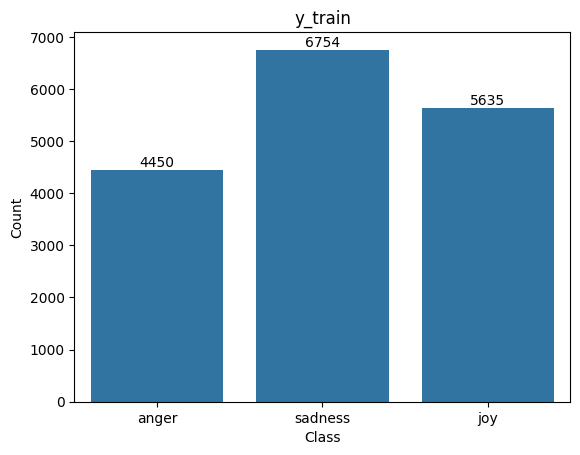

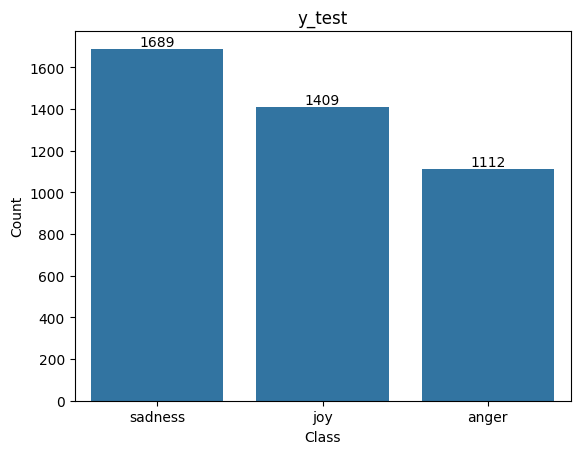

In [8]:

# Plot class distribution
def plot_class_distribution(y, title):
    unique_values, value_counts = np.unique(y, return_counts=True)
    ax = sns.countplot(x=y)
    ax.bar_label(ax.containers[0])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique_values)
    plt.show()
    print()


plot_class_distribution(y_train, 'y_train')
plot_class_distribution(y_test, 'y_test')

### Handling Imbalance Data

Handling imbalanced dataset by applying undersampling on training data.

In [9]:
# apply undersampling to lowest category 'anger'
# Now we going to equal both classes by undersampling
from imblearn.under_sampling import RandomUnderSampler

# Get the count of the minority class (anger)
minority_class_count = y_train.value_counts().min()

# Create a sampling strategy dictionary
sampling_strategy = {
    'sadness': minority_class_count,
    'joy': minority_class_count,
    'anger': minority_class_count,

}

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=7)

# Reshape X_train to a 2D array
X_train_reshaped = X_train.values.reshape(-1, 1)

# Perform undersampling
X_train_downsamp, y_train_downsamp = rus.fit_resample(X_train_reshaped, y_train)

In [ ]:
y_train_downsamp.value_counts()


,count
emotion,
anger,4450
joy,4450
sadness,4450


After applying the undersample method, split the training data further to get validation data from it.

In [11]:
# creating validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_downsamp, y_train_downsamp, stratify=y_train_downsamp, test_size=0.2, random_state=7)
#

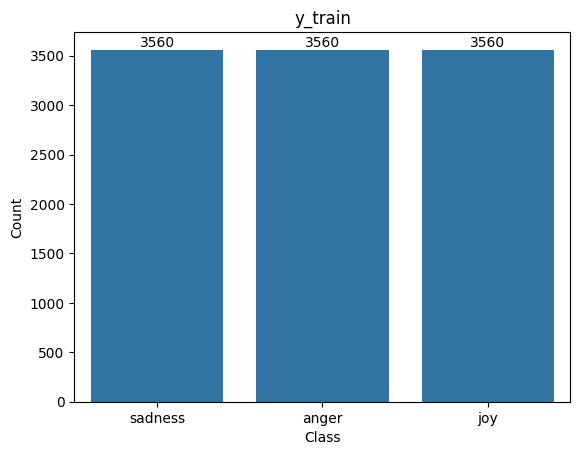

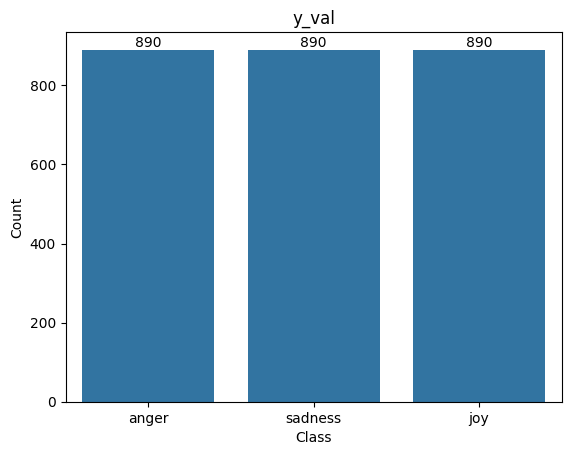

In [12]:

# Plot class distribution
def plot_class_distribution(y, title):
    unique_values, value_counts = np.unique(y, return_counts=True)
    ax = sns.countplot(x=y)
    ax.bar_label(ax.containers[0])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique_values)
    plt.show()
    print()


plot_class_distribution(y_train, 'y_train')
plot_class_distribution(y_val, 'y_val')

In [ ]:
# Convert X_train, X_val, X_test into DataFrames with a 'text' column
# and reset their index.
# ravel(): This is used to flatten the X_train and X_val arrays
#  (which might be multidimensional after resampling) into a 1-dimensional array.
X_train = pd.DataFrame(X_train.ravel(), columns=['text']).reset_index(drop=True)
X_val = pd.DataFrame(X_val.ravel(), columns=['text']).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=['text'], index=X_test.index).reset_index(drop=True)

# Convert y_train, y_val, y_test into DataFrames with an 'emotion' column
# and reset their index.
y_train = pd.DataFrame(y_train, columns=['emotion'], index=y_train.index).reset_index(drop=True)
y_val = pd.DataFrame(y_val, columns=['emotion'], index=y_val.index).reset_index(drop=True)
y_test = pd.DataFrame(y_test, columns=['emotion'], index=y_test.index).reset_index(drop=True)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(10680, 1) (2670, 1) (4210, 1)
(10680, 1) (2670, 1) (4210, 1)


Counting training data

In [ ]:
y_train['emotion'].value_counts()

,count
emotion,
sadness,3560
anger,3560
joy,3560


In [ ]:
X_train['text'].head(3)

,text
0,I came here to upvote the first throwback [NAM...
1,Holy fuck [NAME]!
2,This literally made my day!


Checking GPU

In [ ]:
!nvidia-smi

Sat Feb  8 09:25:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Text Processing

You can use GPU use spacy library if you know about cuda version

In [ ]:
# !pip install -q -U spacy[cuda124]  # Replace cuda116 with your CUDA version if needed

In [ ]:
import spacy
# !python -q -m spacy download en_core_web_sm
# Load the spaCy model for English
nlp = spacy.load("en_core_web_sm")

# spacy.require_gpu()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Building Pipeline for Text Processing

In [ ]:
import re
import spacy
import pandas as pd

# Load the spaCy model for English
nlp = spacy.load("en_core_web_sm")

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stop_words_and_punct(text):
    stop_words = set(nlp.Defaults.stop_words) - {"no", "not", "but"}
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return " ".join(tokens)

def lemmatize_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ != "-PRON-"]
    return " ".join(tokens)

def clean(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub('\[.*?\]', '', text)  # Remove text within square brackets
    text = re.sub('https?://\S+|WWW\.\S+', '', text)  # Remove URLs
    text = re.sub('<.*?>+', '', text)  # Remove HTML tags
    text = re.sub('\n', '', text)  # Remove newline characters
    text = re.sub('\W*\d\W*', '', text)  # Remove digits
    return text

def process_text(text):
    text = clean(text)
    text = remove_emoji(text)
    text = remove_stop_words_and_punct(text)
    text = lemmatize_text(text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Example usage with DataFrames
# Assuming X_train, X_test, X_val are pandas DataFrames with a column 'text'
X_train['text'] = X_train['text'].apply(process_text)
X_test['text'] = X_test['text'].apply(process_text)
X_val['text'] = X_val['text'].apply(process_text)


Saving Train, Validation and Test data into separate sheets of file in a single excel sheet

In [ ]:
!pip install -q xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('multilabel_preprocess_data3class.xlsx', engine='xlsxwriter')

# Concatenate X and y for each dataset
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Write each combined DataFrame to a different worksheet.
train_data.to_excel(writer, sheet_name='Train', index=False)
val_data.to_excel(writer, sheet_name='Validation', index=False)
test_data.to_excel(writer, sheet_name='Test', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.close()  # Use close() instead of save()

## Model Implementation

In [ ]:
pip install -q --upgrade tensorflow keras_nlp

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf

In [ ]:
train_data = pd.read_excel('/kaggle/input/emotion-3classes/multilabel_preprocess_data3class.xlsx', sheet_name='Train')
val_data = pd.read_excel('/kaggle/input/emotion-3classes/multilabel_preprocess_data3class.xlsx', sheet_name='Validation')
test_data = pd.read_excel('/kaggle/input/emotion-3classes/multilabel_preprocess_data3class.xlsx', sheet_name='Test')

### Pre-Trained Bert Model

In [ ]:

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
# import tf_keras as keras
import keras

import keras_hub
import keras_nlp

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_small_en_uncased",trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = keras_nlp.models.BertBackbone.from_preset("bert_small_en_uncased")
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]

### Downloading Embeding Model

In [ ]:
import gensim.downloader as api
# This is a huge model (~1.6 gb) and it will take some time to load
Embedding_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from gensim.models import KeyedVectors
# Embedding_model.save("/kaggle/working/word2vec_google_news_300.model")
Embedding_model = KeyedVectors.load("/kaggle/working/word2vec_google_news_300.model")

### Label Encoding

In [ ]:
# Define a dictionary to map emotions to numerical values alphabetically
emotion_mapping = {
    'anger': 0,
    'joy': 1,
    'sadness': 2,
}

# Apply the mapping to the 'emotion' column of each dataset
train_data['emotion'] = train_data['emotion'].map(emotion_mapping)
val_data['emotion'] = val_data['emotion'].map(emotion_mapping)
test_data['emotion'] = test_data['emotion'].map(emotion_mapping)

### Text Conversion

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 100
# Prepare the text data
tokenizer = Tokenizer()
train_data['text'] = train_data['text'].astype(str)
tokenizer.fit_on_texts(train_data['text'])

val_data['text'] = val_data['text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')
vocab_size = 10000
# Prepare the embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in Embedding_model:
        embedding_matrix[i] = Embedding_model[word]

# Preprocess the text data using BERT preprocessor
train_encodings = preprocessor(train_data['text'].values)
val_encodings = preprocessor(val_data['text'].values)
test_encodings = preprocessor(test_data['text'].values)

# Labels
train_labels = train_data['emotion'].values  # NumPy array of shape (num_samples,)
val_labels = val_data['emotion'].values  # NumPy array of shape (num_samples,)
test_labels = test_data['emotion'].values  # NumPy array of shape (num_samples,)

### Model Building

In [ ]:
# --- BERT Branch ---
for layer in encoder.layers: layer.trainable = False
# Input: raw text strings
text_input_bert = tf.keras.layers.Input(shape=(), dtype=tf.string, name="bert_text_input")
# Preprocess and encode using BERT
bert_inputs  = preprocessor(text_input_bert)
bert_outputs = encoder(bert_inputs)
# Extract pooled_output which represents the sentence embedding
bert_pooled  = bert_outputs["pooled_output"]
# Add dropout to regularize the BERT branch
bert_dropout = tf.keras.layers.Dropout(0.2)(bert_pooled)
# Optionally, add a dense layer to further process the BERT output
bert_dense   = tf.keras.layers.Dense(128, activation='gelu')(bert_dropout)
bert_dense   = tf.keras.layers.BatchNormalization()(bert_dense)

# --- Word2Vec + LSTM Branch ---
# Define your maximum sequence length for tokenized input
max_length = 100  # adjust as needed (ensure your sequences are padded to this length)
# Input: tokenized and padded sequences (integers)
text_input_w2v = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="w2v_text_input")
w2v_embedding  = tf.keras.layers.Embedding(
    input_dim=vocab_size,            # ensure vocab_size is defined
    output_dim=embedding_dim,        # ensure embedding_dim is defined (e.g., 100)
    weights=[embedding_matrix],      # ensure embedding_matrix is prepared
    trainable=False                  # set to True if you want to fine-tune these embeddings
)(text_input_w2v)
w2v_lstm       = tf.keras.layers.LSTM(units=128)(w2v_embedding)
# Optionally, add a dense layer after LSTM
w2v_dense      = tf.keras.layers.Dense(64, activation='gelu')(w2v_lstm)
w2v_dense      = tf.keras.layers.BatchNormalization()(w2v_dense)

# --- Combine the Two Branches ---
combined = tf.keras.layers.Concatenate(name="combined_features")([bert_dense, w2v_dense])
combined = tf.keras.layers.Dropout(0.3)(combined)
combined = tf.keras.layers.Dense(32, activation='gelu')(combined)
combined = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Dense(16, activation='gelu')(combined)
# --- Classification Head ---
# For a 3-class classification problem (adjust units if needed)
output = tf.keras.layers.Dense(3, activation='softmax', name='output')(combined)

# --- Create the Model ---
model = keras.Model(inputs=[text_input_bert, text_input_w2v], outputs=output)

# Optional: compile your model with a suitable loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_text_input           │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_text_classifier_pre… │ [(None, 512), (None,   │              0 │ bert_text_input[0][0]  │
│ (BertTextClassifierPrepr… │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ w2v_text_input            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 512), (None,   │     28,763,648 │ bert_text_classifier_… │
│ (BertBackbone)            │ 512, 512)]             │                │ bert_text_classifier_… │
│                           │                        │                │ bert_text_classifier_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 300)       │      3,000,000 │ w2v_text_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 512)            │              0 │ bert_backbone[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        219,648 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,664 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_features         │ (None, 192)            │              0 │ batch_normalization[0… │
│ (Concatenate)             │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 192)            │              0 │ combined_features[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          6,176 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32)             │            128 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 32,064,867 (122.32 MB)

 Trainable params: 300,771 (1.15 MB)

 Non-trainable params: 31,764,096 (121.17 MB)

In [ ]:
# Calculate class weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['emotion']),
    y=train_data['emotion']
)
class_weights = dict(enumerate(class_weights))

In [ ]:
model.compile(
    optimizer='adam',  # You can also use other optimizers like 'sgd', 'rmsprop', etc.
    loss='sparse_categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']  # You can add more metrics like 'Precision', 'Recall', etc.
)

### Model Fitting

In [ ]:
import numpy as np

# Word2Vec input (tokenized and padded sequences)
w2v_train_input = train_padded  # NumPy array of shape (num_samples, max_length)
w2v_val_input = val_padded  # NumPy array of shape (num_samples, max_length)
w2v_test_input = test_padded  # NumPy array of shape (num_samples, max_length)

# Update the input dictionaries to match the model's expected input layer names:
train_inputs = [
    train_data['text'].values,  # BERT input layer (raw text)
    train_padded                # Word2Vec input layer (tokenized and padded sequences)
]

val_inputs = [
    val_data['text'].values,
    val_padded
]

test_inputs = [
    test_data['text'].values,
    test_padded
]

# Train the model
history = model.fit(
    train_inputs,  # Pass a list of inputs
    train_labels,  # Labels
    validation_data=(val_inputs, val_labels),
    class_weight=class_weights,
    verbose=1,
    epochs=50,  # Adjust the number of epochs
    batch_size=32  # Adjust the batch size
)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 80s 202ms/step - accuracy: 0.4288 - loss: 1.1279 - val_accuracy: 0.5884 - val_loss: 0.8521
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.5407 - loss: 0.9415 - val_accuracy: 0.3865 - val_loss: 3.1343
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 197ms/step - accuracy: 0.5738 - loss: 0.9087 - val_accuracy: 0.6101 - val_loss: 0.8390
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.5737 - loss: 0.8985 - val_accuracy: 0.6247 - val_loss: 0.8077
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.5749 - loss: 0.8968 - val_accuracy: 0.6288 - val_loss: 0.8001
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.5793 - loss: 0.8857 - val_accuracy: 0.6333 - val_loss: 0.8000
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.5912 - loss: 0.8809 - val_accuracy: 0.4498 - val_loss: 2.2065
Epoch 8/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.5954 - loss: 0

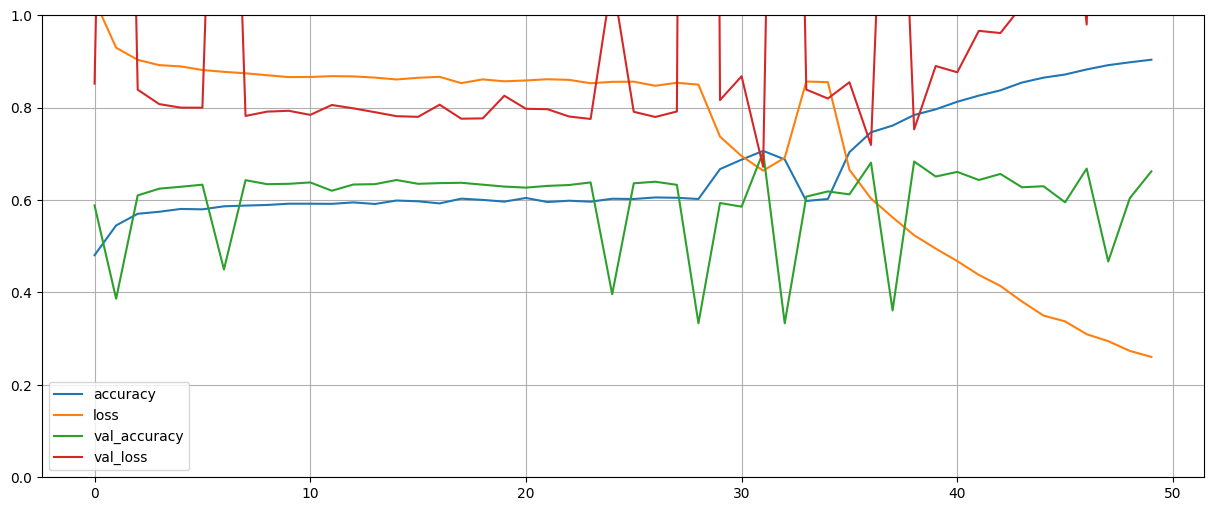

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(15, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Model Evaluation

In [ ]:
model.evaluate(test_inputs, test_labels)

132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.6434 - loss: 1.1299


[1.117688775062561, 0.6486935615539551]

In [ ]:
import numpy as np

y_pred = model.predict(test_inputs)

# your numpy ndarray
arr = y_pred

# empty list to store the index of the maximum value in each list
index_array = []

# extract the index of the maximum value for each list
for i in range(arr.shape[0]):
    index_array.append(np.argmax(arr[i]))

# convert the index_array to a numpy array
y_pred = np.array(index_array)
y_pred

132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step


array([1, 1, 2, ..., 0, 2, 2])

In [ ]:
y_true = test_labels

## Results

In [ ]:
class_labels=['anger', 'joy', 'sadness']
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       anger       0.53      0.66      0.59      1112
         joy       0.70      0.84      0.76      1409
     sadness       0.72      0.48      0.58      1689

    accuracy                           0.65      4210
   macro avg       0.65      0.66      0.64      4210
weighted avg       0.66      0.65      0.64      4210



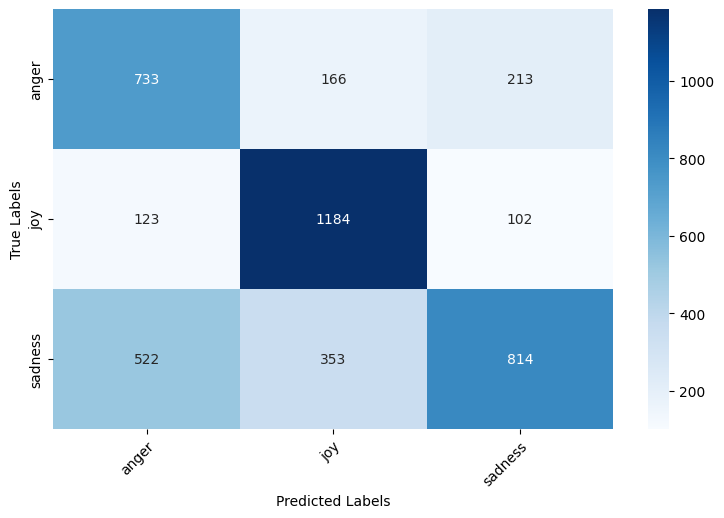

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
# font = {
#     'size'   : 15}
# plt.rc('font', **font)
cm = metrics.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
# Create colored confusion matrix with unique labels
labels = list(class_labels)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
 # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
# Adjust the margins around the figure
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("BERT Results:")
print("----------------------------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


BERT Results:
----------------------------
Accuracy: 0.6486935866983373
Precision: 0.6624371550878215
Recall: 0.6486935866983373
F1 Score: 0.6419476614617399


Hamming loss is a measure of the fraction of labels that are incorrectly predicted in a multi-label classification problem. It is calculated as the ratio of the number of wrong labels to the total number of labels. Essentially, it describes how well a model performs in terms of label prediction accuracy.

In [ ]:
from sklearn.metrics import hamming_loss
ham_loss = hamming_loss(y_true, y_pred)
print("Hamming Loss:", ham_loss)

Hamming Loss: 0.35130641330166273


## Conclusion

Overall, the BERT model yielded average results due to the use of a smaller pretrained version. A larger pretrained BERT model would likely have produced better outcomes.